In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from src.med_project.config import PROCESSED_DATA_DIR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
X_train = pd.read_csv(PROCESSED_DATA_DIR / 'X_train.csv')
X_test = pd.read_csv(PROCESSED_DATA_DIR / 'X_test.csv')
y_train = pd.read_csv(PROCESSED_DATA_DIR / 'y_train.csv').values.ravel()
y_test = pd.read_csv(PROCESSED_DATA_DIR / 'y_test.csv').values.ravel()

final_results = []

In [13]:
# LINEAR REGRESSION
lr_model=LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr=lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.6f}")
print(f"Linear Regression R2: {r2_lr:.6f}")

final_results.append({"Model":"Linear Regression","RMSE":rmse_lr, "R2": r2_lr})

Linear Regression RMSE: 0.726867
Linear Regression R2: 0.993505


In [23]:
#RIDGE
ridge_model = Ridge(alpha=1.0,random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge=ridge_model.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {rmse_ridge:.6f}")
print(f"Ridge Regression R2: {r2_ridge:.6f}")

final_results.append({"Model":"Ridge","RMSE":rmse_ridge, "R2": r2_ridge})

Ridge Regression RMSE: 0.726870
Ridge Regression R2: 0.993505


In [14]:
#LASSO
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso RMSE: {rmse_lasso:.6f}")
print(f"Lasso R2: {r2_lasso:.6f}")
final_results.append({"Model": "Lasso", "RMSE": rmse_lasso, "R2": r2_lasso})

Lasso RMSE: 0.806416
Lasso R2: 0.992006


In [11]:
#XGBOOST
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R2: {r2_xgb:.6f}")
final_results.append({"Model": "XGBoost", "RMSE": rmse_xgb, "R2": r2_xgb})

XGBoost RMSE: 0.3050
XGBoost R2: 0.998856


In [28]:
#TUNING
#Ridge
linear_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

ridge_grid = GridSearchCV(Ridge(random_state=42), linear_params, scoring='neg_root_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)

print(f"Najlepsze Ridge Alpha: {ridge_grid.best_params_}")
print(f"Najlepsze Ridge RMSE: {-ridge_grid.best_score_:.4f}")

#Lasso
lasso_grid = GridSearchCV(Lasso(random_state=42), linear_params, scoring='neg_root_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)

print(f"Najlepsze Lasso Alpha: {lasso_grid.best_params_}")
print(f"Najlepsze Lasso RMSE: {-lasso_grid.best_score_:.4f}")

best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_

#xgboost
xgb_params = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 3, 4],
    'min_child_weight': [5, 7, 10, 15],
    'learning_rate': [0.005, 0.01, 0.02, 0.05],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [1, 2, 5]
}
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=xgb_params,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print(f"Najlepsze parametry XGBoost: {xgb_search.best_params_}")
print(f"Najlepsze XGBoost RMSE: {-xgb_search.best_score_:.4f}")

best_xgb = xgb_search.best_estimator_

Najlepsze Ridge Alpha: {'alpha': 0.01}
Najlepsze Ridge RMSE: 0.7321
Najlepsze Lasso Alpha: {'alpha': 0.001}
Najlepsze Lasso RMSE: 0.7320
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Najlepsze parametry XGBoost: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Najlepsze XGBoost RMSE (Cross-Val): 0.1821


Text(0.5, 0, 'Importance')

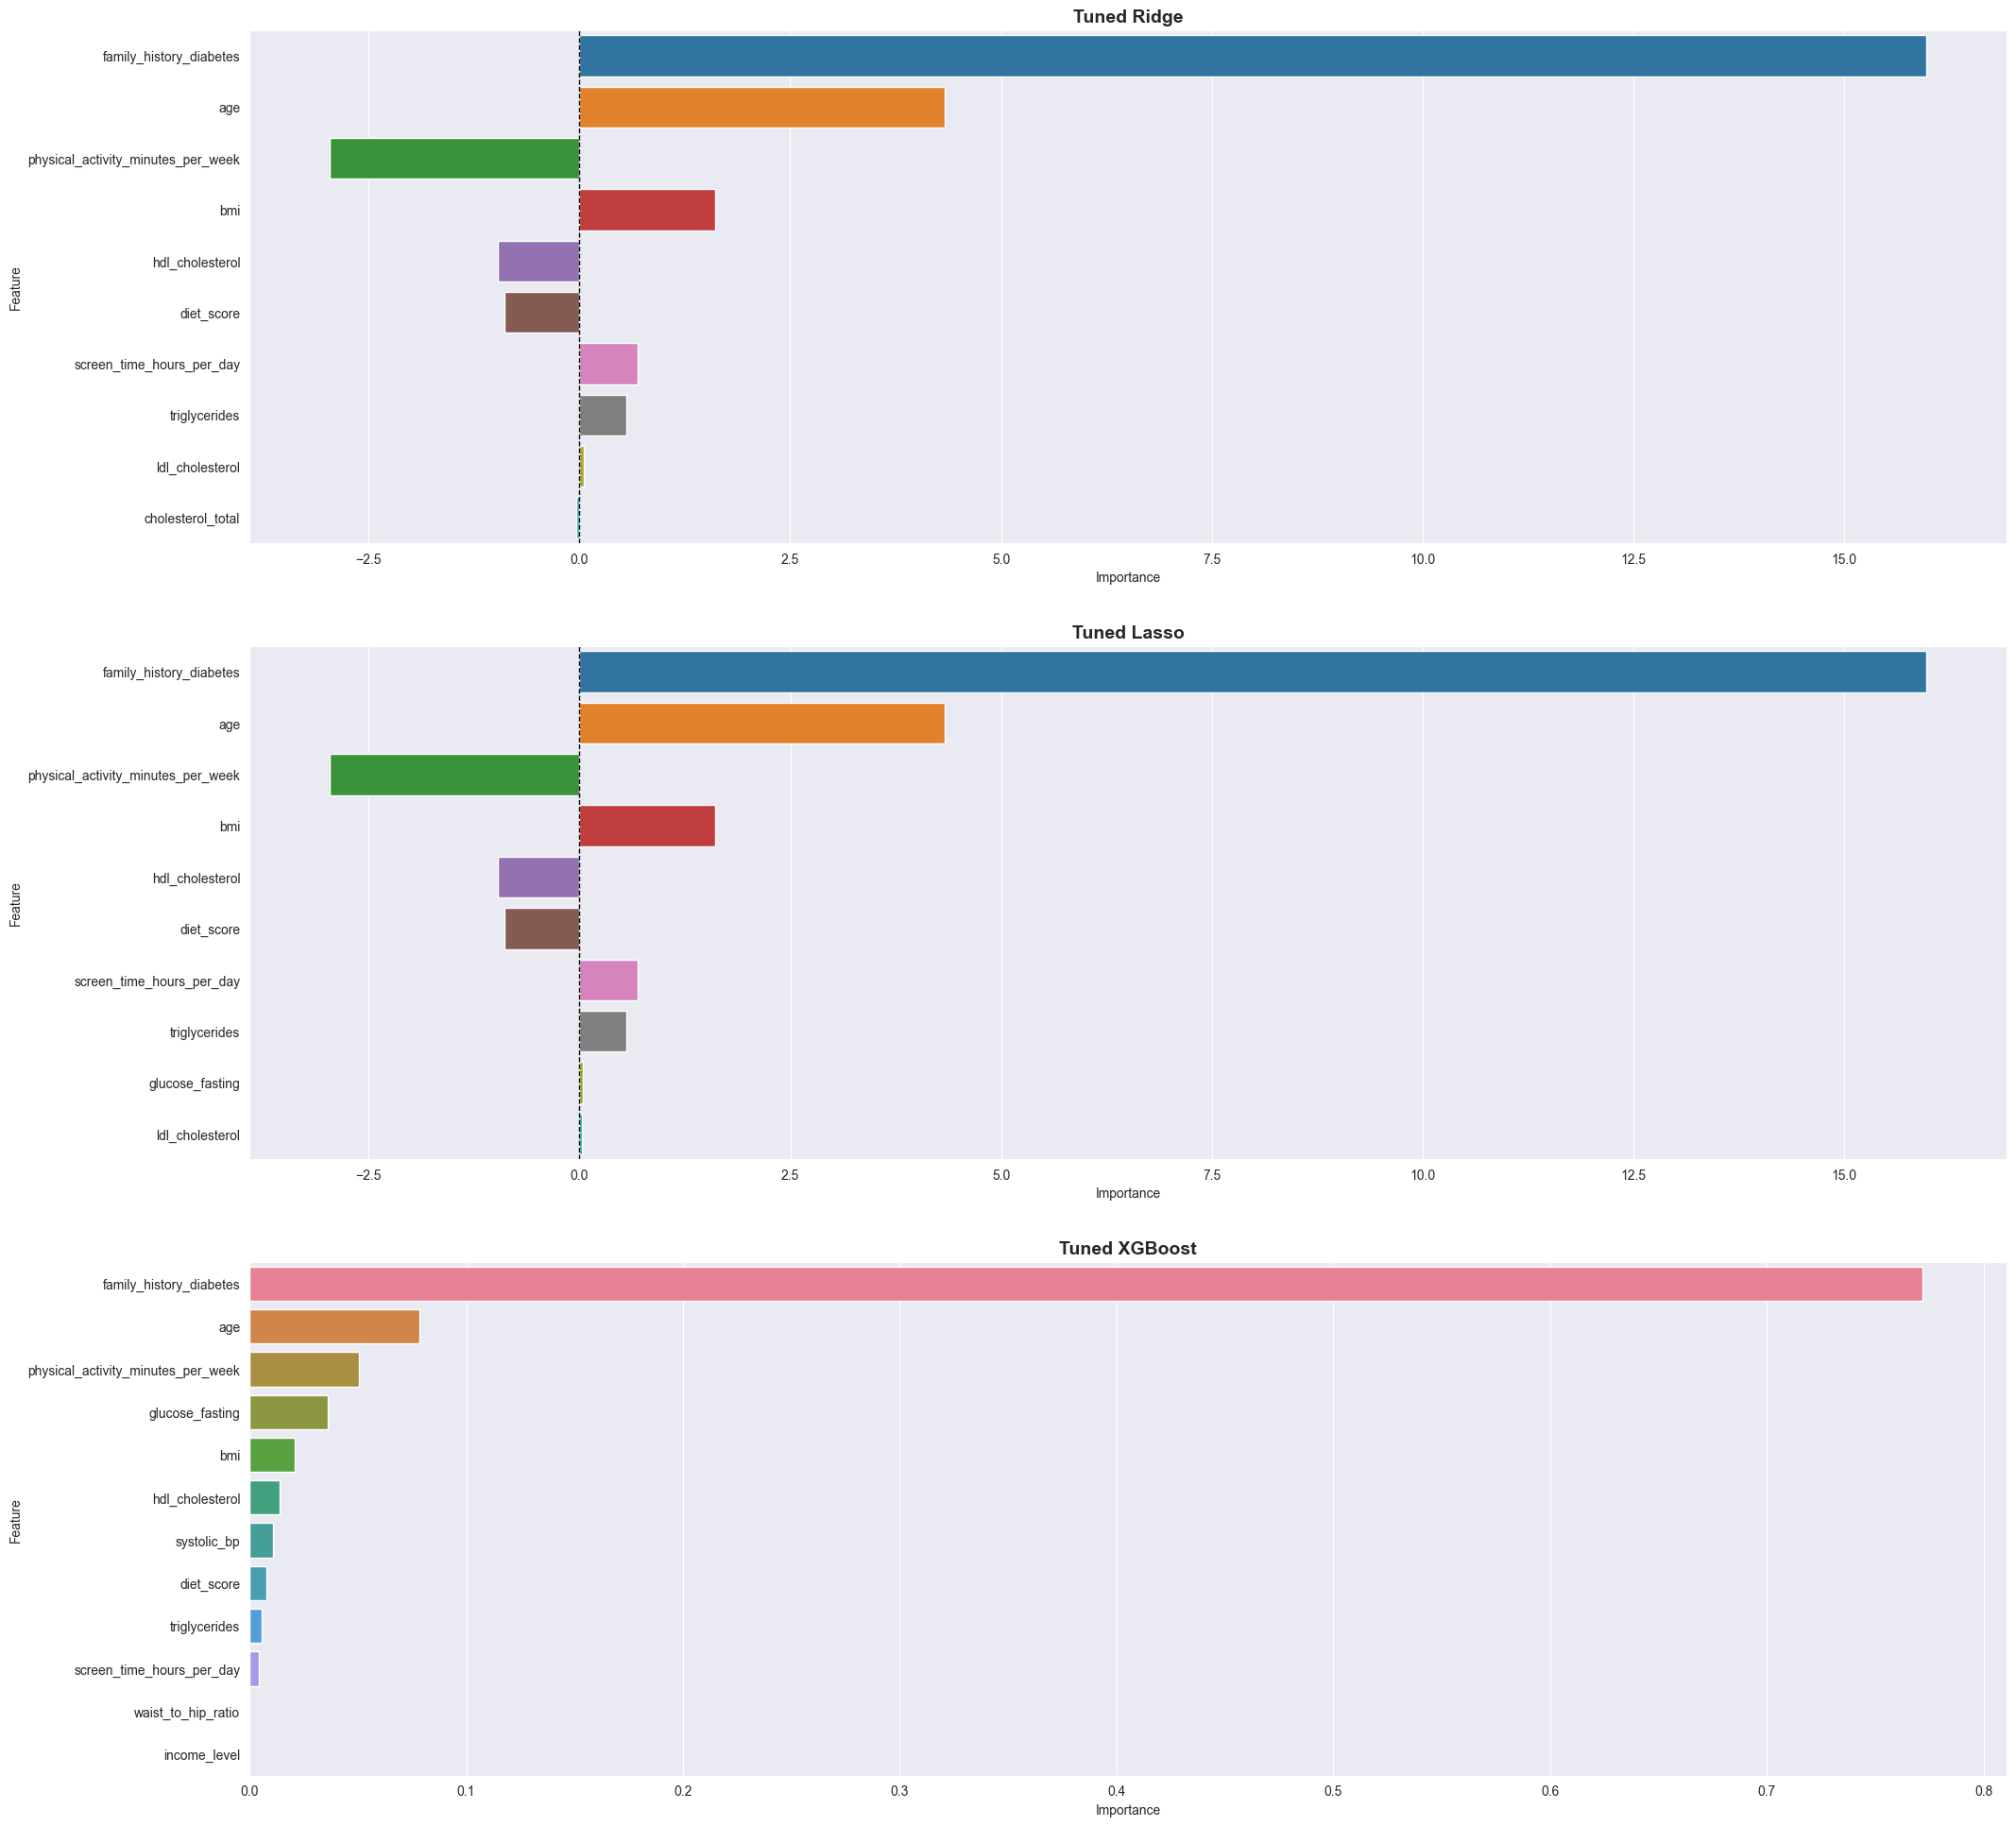

In [42]:
#COMPARISON
feature_names = X_train.columns
fig, axes = plt.subplots(3,1, figsize=(24, 24))

#Ridge
df_ridge = pd.DataFrame({
    'Feature': feature_names,
    'Value': best_ridge.coef_
})

df_ridge = df_ridge.reindex(df_ridge['Value'].abs().sort_values(ascending=False).index).head(10)

sns.barplot(data=df_ridge, x='Value', y='Feature', ax=axes[0], hue='Feature')
axes[0].set_title("Tuned Ridge", fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel("Importance")

#Lasso
df_lasso = pd.DataFrame({
    'Feature': feature_names,
    'Value': best_lasso.coef_
})
df_lasso = df_lasso.reindex(df_lasso['Value'].abs().sort_values(ascending=False).index).head(10)

sns.barplot(data=df_lasso, x='Value', y='Feature', ax=axes[1], hue='Feature')
axes[1].set_title("Tuned Lasso", fontsize=14, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel("Importance")

#xgboost
df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Value': best_xgb.feature_importances_
})
df_xgb = df_xgb.sort_values(by='Value', ascending=False).head(12)

sns.barplot(data=df_xgb, x='Value', y='Feature', ax=axes[2], hue='Feature')
axes[2].set_title("Tuned XGBoost", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Importance")


               Model      RMSE       MAE  R2 Score
3      Tuned XGBoost  0.180657  0.142430  0.999599
2        Tuned Lasso  0.726802  0.434638  0.993506
0  Linear Regression  0.726867  0.434290  0.993505
1        Tuned Ridge  0.726867  0.434290  0.993505


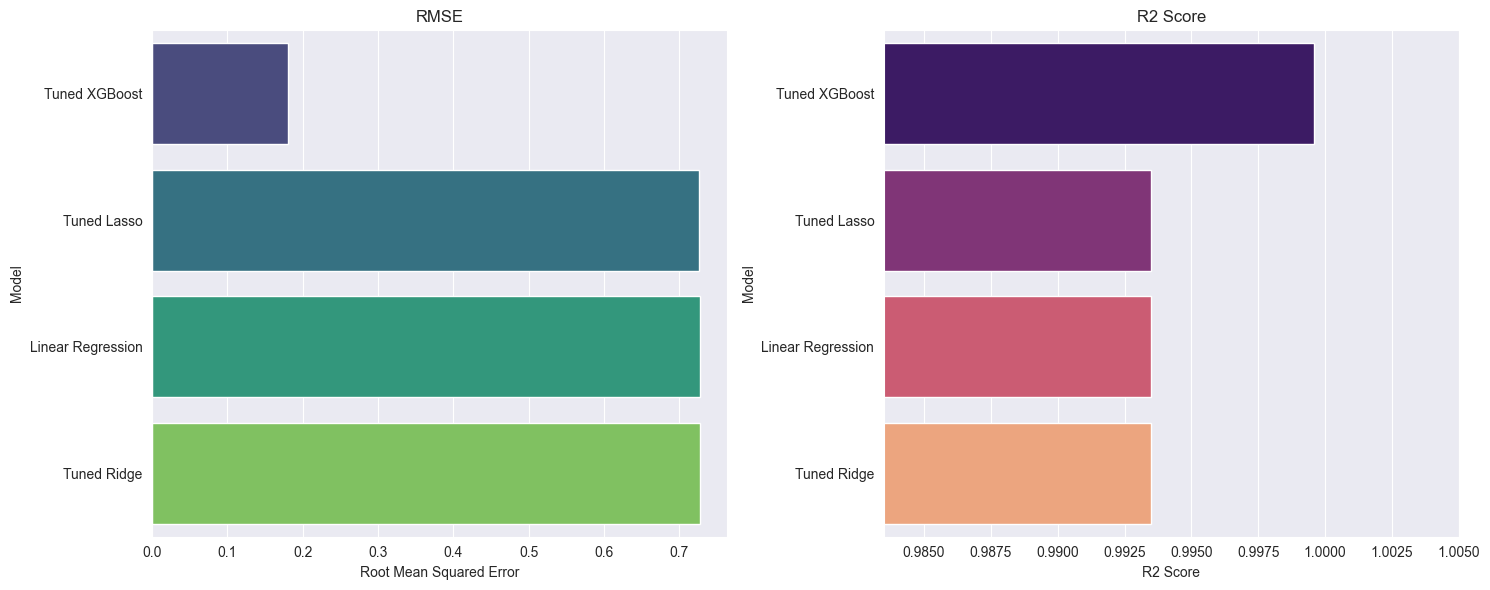

In [48]:
# FINAL TEST
final_models = {
    "Linear Regression": lr_model,
    "Tuned Ridge": best_ridge,
    "Tuned Lasso": best_lasso,
    "Tuned XGBoost": best_xgb
}

results_comparison = []

for name, model in final_models.items():
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_comparison.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2 Score": r2
    })

comparison_df = pd.DataFrame(results_comparison).sort_values(by="RMSE")

print(comparison_df)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x="RMSE", y="Model", data=comparison_df, palette="viridis", ax=axes[0], hue='Model', legend=False)
axes[0].set_title("RMSE")
axes[0].set_xlabel("Root Mean Squared Error")

sns.barplot(x="R2 Score", y="Model", data=comparison_df, palette="magma", ax=axes[1], hue='Model', legend=False)
axes[1].set_title("R2 Score")
axes[1].set_xlabel("R2 Score")
axes[1].set_xlim(comparison_df["R2 Score"].min() - 0.01, 1.005)

plt.tight_layout()
plt.show()

top_features = [
    'family_history_diabetes',
    'age',
    'physical_activity_minutes_per_week',
    'bmi',
    'glucose_fasting'
]

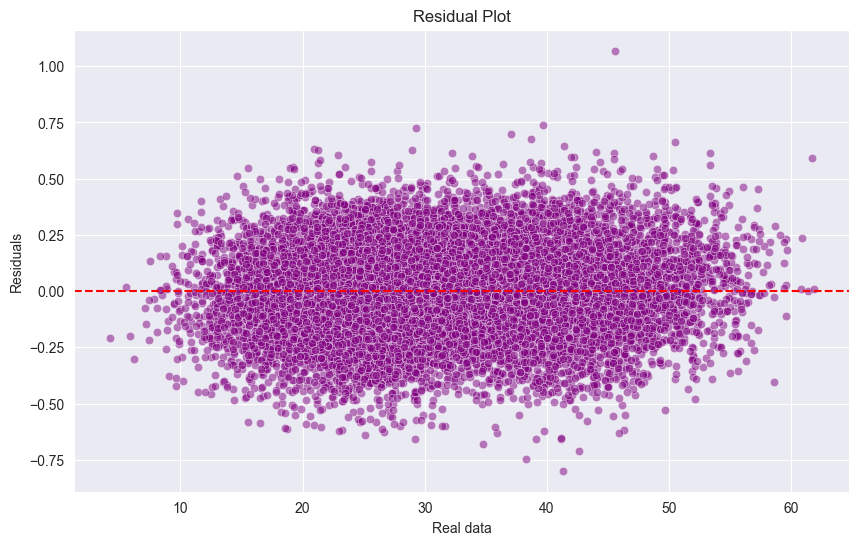

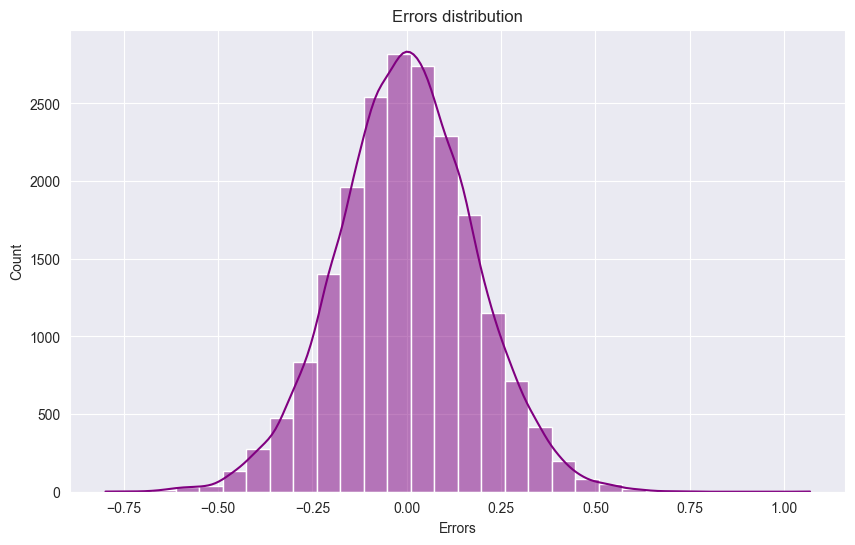

In [50]:
#RESIDUALS ANALYSIS
y_pred_final = final_models["Tuned XGBoost"].predict(X_test)
residuals = y_test - y_pred_final

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Real data")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title("Errors distribution")
plt.xlabel("Errors")
plt.show()